# Subject 4: Latency and capacity estimation for a network connection from asymmetric measurements

## Exercise's Instructions
**Required competence: linear regression**

A simple and frequently used model for the performance of a network connection consists of assuming that the time T required for sending a message depends mainly on its size S (number of bytes) and two quantities that characterize the connection: the latency L (in seconds) and the capacity C (in bytes/second). The relation between these four quantities is T(S) = L + S/C. This model neglects a large number of details. L and C certainly depend on the chosen communication protocol, but also to some extent on S. Moreover, a measurement of T(S) includes a strong random component. What we are interested in here is the mean time required for sending a message of a given length.

Your task is to estimate L and C from a series of observations of T for different values of S. Prepare your analysis as a replicable computational document that starts with reading the raw data available for two different connections, which were obtained using ping:


    - The first dataset explores a short on-campus connection: http://mescal.imag.fr/membres/arnaud.legrand/teaching/2014/RICM4_EP_ping/liglab2.log.gz
    - The second dataset measures the performance of a connection to a remote Web site that is popular and therefore has a heavy load: http://mescal.imag.fr/membres/arnaud.legrand/teaching/2014/RICM4_EP_ping/stackoverflow.log.gz

The two files contain the raw output of ping, which has been executed in a loop while varying the message size randomly. Each line looks like

```
[1421761682.052172] 665 bytes from lig-publig.imag.fr (129.88.11.7): icmp_seq=1 ttl=60 time=22.5 ms
```
In the beginning, between brackets, you see the date on which the measurement was taken, expressed in seconds since January 1, 1970. The size of the message in bytes comes next, followed by the name of the target machine and its IP address, which are normally the same for all lines in a given dataset. At the end of the line, we have the message round trip time in milliseconds. The other information, icmp_seq and ttl, are not important for our analysis. Watch out, lines can be incomplete, you have to verify each line before extracting information from it!

Your mission, should you choose to accept it:

1. Start by working on the first dataset (liglab2). Plot the time evolution of transmission time, if useful at different moments in time and/or on different time scales, in order to evaluate the temporal stability of the phenomenon. Can the variations be explained solely by message size?
2. Plot the transmission time as a function of message size. You should observe a "disruption", a size starting from which the variability changes qualitatively. Estimate this time graphically, in order to treat the two classes of message size separately.
3. Perform a linear regression for each class and estimate the corresponding values of L and C. Superpose the result of this regression onto the preceding plot.
4. Repeat the preceding steps for the second dataset (stackoverflow)
5. Submit your work in FUN

## 1. Extracting data from log file


Importing libraries needed

In [14]:
%matplotlib inline
import pandas as pd # Library for dataframes
import matplotlib.pyplot as plt # Library for plotting
from scipy import stats # Library for linear regression

Extracting raw data and defining environment variables

In [15]:
file = open('liglab2.log','r')  #Open data file in .log extension
data = file.readlines() # Saving each text line into list variable

tx_time = [] # transmission time list variable
tx_time_filt = [] # transmission time filtered list variable (there are no time trasmission data in data file)
time_scale = [] # Time of measures list
messag_size = [] # Message size list

Filtering missing data in trasmission time
Due to data is stored in string form, for extracting the needed data from each line as:
```
[1421761682.052172] 665 bytes from lig-publig.imag.fr (129.88.11.7): icmp_seq=1 ttl=60 time=22.5 ms
```
It is possible to use the method "split( )" to separate the data from the rest of characters. This process is the same for *time of measures*, *transmission time* and *message size*
There are two for loops due to the first one is to find missing data and extracting the other data variables. The second is dedicated to extract the unit measure "ms" string from the *transmission time* data.

In [16]:

#Loop for filtering missing data
j=0 #Counter of filtered data
for i in range(0,len(data)):
    mem = data[i][:].split('ttl=60')[1].split('\n')[0] # split function allows to separate the string line and extract the data
    if mem != '':
            tx_time.insert(j,mem)
            time_scale.insert(j,data[i][:].split('[')[1].split(']')[0])
            messag_size.insert(j,data[i][:].split('] ')[1].split(' bytes')[0])
            j+=1 
#Loop for extract "ms" string from transmission time data
for i in range(0,len(tx_time)):
    
    tx_time_filt.insert(i,tx_time[i][:].split('time=')[1].split(' ms')[0])


## 2. Plotting *Transmission Time* and *Message Size*

To use the data, a convinient form is working with dataframes. For this reason, all data is stored in a dataframe variable ``df``. After that, *Transmission Time* and *Message Size* are converted from string data to float and integer respectively.

In [17]:

#Constructing dataframe
df = pd.DataFrame(list(zip(time_scale, messag_size,tx_time_filt)),
               columns =['Time Scale', 'Message Size','Transmission Time'])
#Converting the type of data into float and integer

df["Transmission Time"] = pd.to_numeric(df["Transmission Time"], downcast='float')
df["Message Size"] = pd.to_numeric(df["Message Size"], downcast='integer')

#Plot with all data captured
figure1, (ax1,ax2) = plt.subplots(2,1)

df.plot(y="Transmission Time",ax=ax1,color='blue',style='.',legend=False)
ax1.set_xlabel('Measure')
ax1.set_ylabel('Tx Time(ms)')
ax1.minorticks_on()
ax1.grid(which='major', linestyle='-', linewidth='0.5', color='red')
ax1.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

df.plot(y="Message Size",ax=ax2,color='green',style='.',legend=False)
ax2.set_xlabel('Measure')
ax2.set_ylabel('Message Size(Bytes)')
ax2.minorticks_on()
ax2.grid(which='major', linestyle='-', linewidth='0.5', color='red')
ax2.grid(which='minor', linestyle=':', linewidth='0.5', color='black')


#Zoomed plot from last plot, centered at a high deviation of transmission time"
figure2, (ax1,ax2) = plt.subplots(2,1)

df.plot(y="Transmission Time",ax=ax1,color='blue',style='.',legend=False)
ax1.set_xlim(20250, 20750)
ax1.set_xlabel('Measure')
ax1.set_ylabel('Tx Time(ms)')
ax1.minorticks_on()
ax1.grid(which='major', linestyle='-', linewidth='0.5', color='red')
ax1.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

df.plot(y="Message Size",ax=ax2,color='green',style='.',legend=False)
ax2.set_xlim(20250, 20750)
ax2.set_xlabel('Measure')
ax2.set_ylabel('Message Size(Bytes)')
ax2.minorticks_on()
ax2.grid(which='major', linestyle='-', linewidth='0.5', color='red')
ax2.grid(which='minor', linestyle=':', linewidth='0.5', color='black')



Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f418d85e730> (for post_execute):


TypeError: can't multiply sequence by non-int of type 'float'

TypeError: can't multiply sequence by non-int of type 'float'

<Figure size 432x288 with 2 Axes>

TypeError: can't multiply sequence by non-int of type 'float'

<Figure size 432x288 with 2 Axes>

From the four graphs above, it is clear to state there is no relation that explains the variation of *Transmission Time* a cause of *Message Size*

## 3. *Transmission Time* as a function of *Message Size* 

The next step to visualize the relation between *Transmission Time* and *Message Size* is plotting the first as independent variable and the second dependent variable.

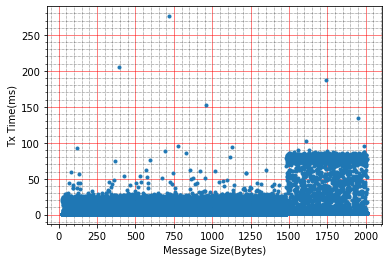

In [151]:
figure2, ax = plt.subplots()

df.plot(x="Message Size", y="Transmission Time", style='.', ax=ax,legend=False)
ax.set_xlabel('Message Size(Bytes)')
ax.set_ylabel('Tx Time(ms)')
ax.minorticks_on()
ax.grid(which='major', linestyle='-', linewidth='0.5', color='red')
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

We notice there hare a disruption arround to *Message Size* equal to $1500(B)$. This allows us to classify into two groups the data. One of them goes from zero to $1500$ and the other from $1500$ to $2000$. Doing this more accurately, we have to make a zoom around $1500(B)$ respect to the last plot:

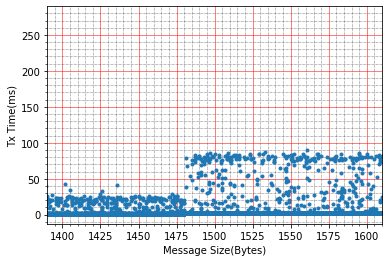

In [152]:
figure3, ax = plt.subplots()

df.plot(x="Message Size", y="Transmission Time", style='.', ax=ax,legend=False)
ax.set_xlabel('Message Size(Bytes)')
ax.set_ylabel('Tx Time(ms)')
ax.set_xlim(1390, 1610)
ax.minorticks_on()
ax.grid(which='major', linestyle='-', linewidth='0.5', color='red')
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

The last figure shows the disruption is not exactly located at $1500(B)$, so we do another zoom between $1475(B)$ and $1495(B)$

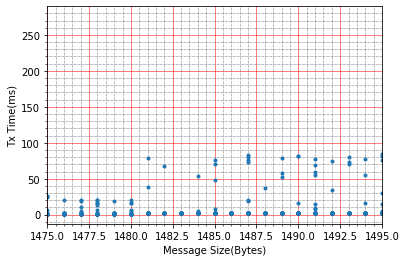

In [153]:
figure4, ax = plt.subplots()

df.plot(x="Message Size", y="Transmission Time", style='.', ax=ax,legend=False)
ax.set_xlabel('Message Size(Bytes)')
ax.set_ylabel('Tx Time(ms)')
ax.set_xlim(1475, 1495)
ax.minorticks_on()
ax.grid(which='major', linestyle='-', linewidth='0.5', color='red')
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

Now is clear the disruption occurs at $1480(B)$

## Classification of disruption groups

As we can see in the last plot, there are a several values of *Transmission Time* variable for $1480(B)$, the start point to classify is to find the location of these point in the dataframe.

In [154]:
# Sorting the data according to "Message Size" column

sort_df = df.sort_values(by=['Message Size'],ignore_index=True)
sort_df

Time Scale  Message Size  Transmission Time
0      1421770806.842532            24           1.130000
1      1421767547.555943            24           1.120000
2      1421764655.951966            24           1.210000
3      1421766751.339029            24           1.160000
4      1421770669.071285            24           1.100000
...                  ...           ...                ...
44031  1421768501.216148          2007           2.290000
44032  1421766239.850005          2007           2.480000
44033  1421765463.802747          2007          36.200001
44034  1421770854.067229          2007           2.350000
44035  1421766451.583931          2007           2.490000

[44036 rows x 3 columns]

Now it is necessary to obtain the indexes for $1480(B)$ values of the  *Message Size* column in dataframe

In [155]:
idx = sort_df.index[sort_df['Message Size'] == 1480].tolist()
lastidx = idx[-1]
print(idx)
print(lastidx) #Last index corresponds to the separation between the groups

[32649, 32650, 32651, 32652, 32653, 32654, 32655, 32656, 32657, 32658, 32659, 32660, 32661, 32662, 32663, 32664, 32665, 32666]
32666


With the row number detected, It is time to construct the groups. Group 1 is sorted data up to $1480(B)$ and the rest correspond to the Group 2.

       Message Size  Transmission Time
0                24           1.130000
1                24           1.120000
2                24           1.210000
3                24           1.160000
4                24           1.100000
...             ...                ...
32662          1480           1.530000
32663          1480          16.799999
32664          1480           4.940000
32665          1480           6.420000
32666          1480           1.550000

[32667 rows x 2 columns]
       Message Size  Transmission Time
32667          1481           2.280000
32668          1481           2.150000
32669          1481           2.250000
32670          1481           2.230000
32671          1481          38.099998
...             ...                ...
44031          2007           2.290000
44032          2007           2.480000
44033          2007          36.200001
44034          2007           2.350000
44035          2007           2.490000

[11369 rows x 2 columns]


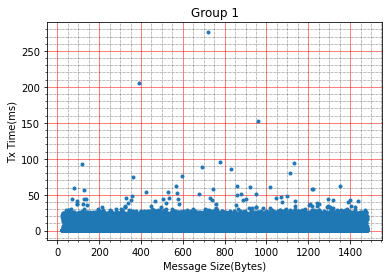

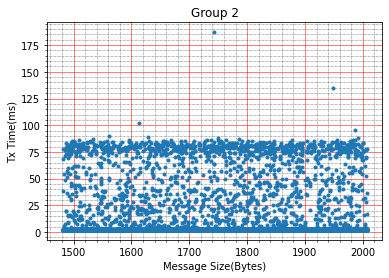

In [156]:
# Defining the groups
group1 = sort_df.iloc[:lastidx+1,1:3]
group2 = sort_df.iloc[lastidx+1:,1:3]
# Exploring the groups in table format
print(group1)
print(group2)
# Proving the number of rows are well splited in the groups
len(sort_df)==len(group1)+len(group2)

#Plotting the groups

figure5, ax1 = plt.subplots()

group1.plot(x="Message Size", y="Transmission Time", style='.', ax=ax1,legend=False)
ax1.set_xlabel('Message Size(Bytes)')
ax1.set_ylabel('Tx Time(ms)')
ax1.set_title('Group 1')

ax1.minorticks_on()
ax1.grid(which='major', linestyle='-', linewidth='0.5', color='red')
ax1.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

figure6, ax2 = plt.subplots()

group2.plot(x="Message Size", y="Transmission Time", style='.', ax=ax2,legend=False)
ax2.set_xlabel('Message Size(Bytes)')
ax2.set_ylabel('Tx Time(ms)')
ax2.set_title('Group 2')

ax2.minorticks_on()
ax2.grid(which='major', linestyle='-', linewidth='0.5', color='red')
ax2.grid(which='minor', linestyle=':', linewidth='0.5', color='black')


## 4. Linear Regression and Parameters Estimation

Linear regression has the form:

$$y = solpe\cdot x + intercept$$

and the relation we are trying to model is:

$$T(S) = \frac{1}{C}\cdot S + L$$

so $C = \frac{1}{slope}$ and $L = intercept $

In [157]:
slope1, intercept1, r1, p1, std_err1 = stats.linregress(group1['Message Size'], group1['Transmission Time'])
print('C1 = ',1/slope1, 'in (B/ms)')
print('L1 = ',intercept1,'in (ms)')
print('Std1 = ',std_err1)
print('r1index = ',r1)

def func1(x):
    return slope1 * x + intercept1

model1 = list(map(func1, group1['Message Size']))

C1 =  3064.5146307032574 in (B/ms)
L1 =  3.275673965631576 in (ms)
Std1 =  8.496511589950841e-05
r1index =  0.02124507571596384


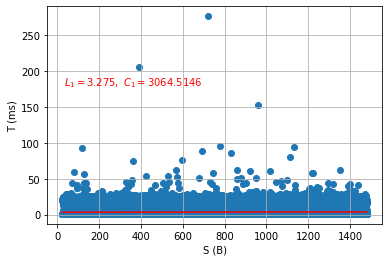

In [158]:

plt.scatter(group1['Message Size'], group1['Transmission Time'])
plt.plot(group1['Message Size'], model1, color="red")
plt.xlabel('S (B)')
plt.text(30, 180, r'$L_1=3.275,\ C_1=3064.5146$',color='red')
plt.ylabel('T (ms)')
plt.grid(True)
plt.show() 

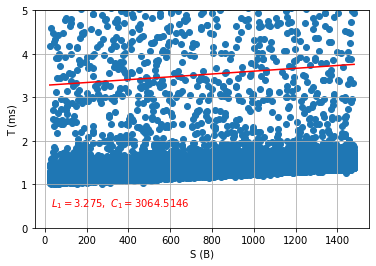

In [159]:
plt.scatter(group1['Message Size'], group1['Transmission Time'])
plt.plot(group1['Message Size'], model1, color="red")
plt.xlabel('S (B)')
plt.text(30, 0.5, r'$L_1=3.275,\ C_1=3064.5146$',color='red')
plt.ylabel('T (ms)')
plt.ylim(0, 5)
plt.grid(True)
plt.show() 

In [160]:
slope2, intercept2, r2, p2, std_err2 = stats.linregress(group2['Message Size'], group2['Transmission Time'])
print('C2 = ',1/slope2, 'in (B/ms)')
print('L2 = ',intercept2,'in (ms)')
print('Std2 = ',std_err1)
print('r2index = ',r2)

def func2(x):
    return slope2* x + intercept2

model2 = list(map(func2, group2['Message Size']))

C2 =  387.76040454764706 in (B/ms)
L2 =  5.289833455834813 in (ms)
Std2 =  8.496511589950841e-05
r2index =  0.018872155725227994


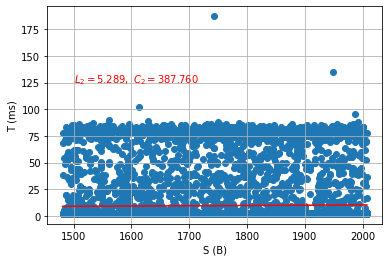

In [161]:
plt.scatter(group2['Message Size'], group2['Transmission Time'])
plt.plot(group2['Message Size'], model2, color="red")
plt.xlabel('S (B)')
plt.text(1500, 125, r'$L_2=5.289,\ C_2=387.760$',color='red')
plt.ylabel('T (ms)')
plt.grid(True)
plt.show() 

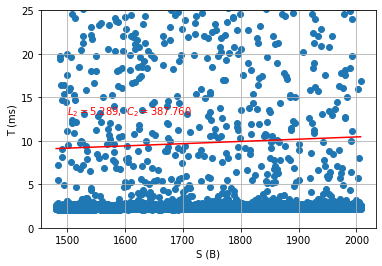

In [162]:
plt.scatter(group2['Message Size'], group2['Transmission Time'])
plt.plot(group2['Message Size'], model2, color="red")
plt.xlabel('S (B)')
plt.text(1500, 13, r'$L_2=5.289,\ C_2=387.760$',color='red')
plt.ylabel('T (ms)')
plt.ylim(0, 25)
plt.grid(True)
plt.show() 

## 5. Repiting the steps for stackoverflow dataset

a) Loading database

In [163]:
file = open('stackoverflow.log','r')  #Open data file in .log extension
data = file.readlines() # Saving each text line into list variable
tx_time = [] # transmission time list variable
tx_time_filt = [] # transmission time filtered list variable (there are no time trasmission data in data file)
time_scale = [] # Time of measures list
messag_size = [] # Message size list

b) Filtering the missing data

In [164]:
#Loop for filtering missing data
j=0 #Counter of filtered data
for i in range(0,len(data)):
    mem = data[i][:].split('ttl=50')[1].split('\n')[0] # split function allows to separate the string line and extract the data
    if mem != '':
            tx_time.insert(j,mem)
            time_scale.insert(j,data[i][:].split('[')[1].split(']')[0])
            messag_size.insert(j,data[i][:].split('] ')[1].split(' bytes')[0])
            j+=1 
#Loop for extract "ms" string from transmission time data
for i in range(0,len(tx_time)):
    
    tx_time_filt.insert(i,tx_time[i][:].split('time=')[1].split(' ms')[0])

c) Plotting the Transmission Time and Message Size

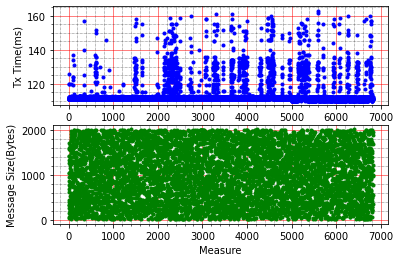

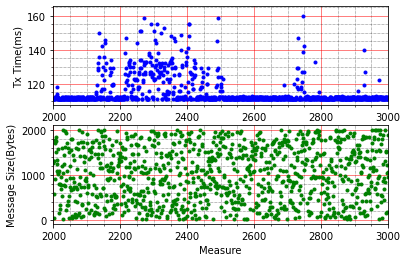

In [165]:
#Constructing dataframe
df = pd.DataFrame(list(zip(time_scale, messag_size,tx_time_filt)),
               columns =['Time Scale', 'Message Size','Transmission Time'])
#Converting the type of data into float and integer

df["Transmission Time"] = pd.to_numeric(df["Transmission Time"], downcast='float')
df["Message Size"] = pd.to_numeric(df["Message Size"], downcast='integer')

#Plot with all data captured
figure1, (ax1,ax2) = plt.subplots(2,1)

df.plot(y="Transmission Time",ax=ax1,color='blue',style='.',legend=False)
ax1.set_xlabel('Measure')
ax1.set_ylabel('Tx Time(ms)')
ax1.minorticks_on()
ax1.grid(which='major', linestyle='-', linewidth='0.5', color='red')
ax1.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

df.plot(y="Message Size",ax=ax2,color='green',style='.',legend=False)
ax2.set_xlabel('Measure')
ax2.set_ylabel('Message Size(Bytes)')
ax2.minorticks_on()
ax2.grid(which='major', linestyle='-', linewidth='0.5', color='red')
ax2.grid(which='minor', linestyle=':', linewidth='0.5', color='black')


#Zoomed plot from last plot, centered at a high deviation of transmission time"
figure2, (ax1,ax2) = plt.subplots(2,1)

df.plot(y="Transmission Time",ax=ax1,color='blue',style='.',legend=False)
ax1.set_xlim(2000, 3000)
ax1.set_xlabel('Measure')
ax1.set_ylabel('Tx Time(ms)')
ax1.minorticks_on()
ax1.grid(which='major', linestyle='-', linewidth='0.5', color='red')
ax1.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

df.plot(y="Message Size",ax=ax2,color='green',style='.',legend=False)
ax2.set_xlim(2000, 3000)
ax2.set_xlabel('Measure')
ax2.set_ylabel('Message Size(Bytes)')
ax2.minorticks_on()
ax2.grid(which='major', linestyle='-', linewidth='0.5', color='red')
ax2.grid(which='minor', linestyle=':', linewidth='0.5', color='black')


d) Finding the disruption point

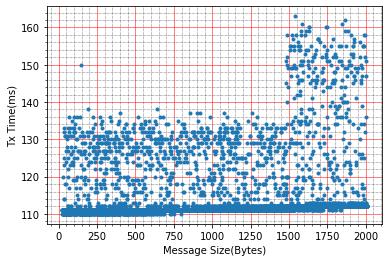

In [166]:
figure10, ax = plt.subplots()

df.plot(x="Message Size", y="Transmission Time", style='.', ax=ax,legend=False)
ax.set_xlabel('Message Size(Bytes)')
ax.set_ylabel('Tx Time(ms)')
ax.minorticks_on()
ax.grid(which='major', linestyle='-', linewidth='0.5', color='red')
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

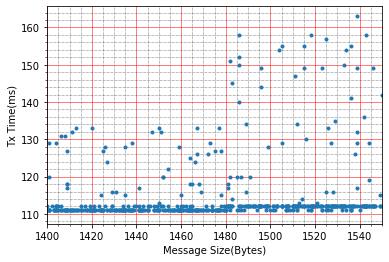

In [167]:
figure10, ax = plt.subplots()

df.plot(x="Message Size", y="Transmission Time", style='.', ax=ax,legend=False)
ax.set_xlabel('Message Size(Bytes)')
ax.set_ylabel('Tx Time(ms)')
ax.set_xlim(1400, 1550)
ax.minorticks_on()
ax.grid(which='major', linestyle='-', linewidth='0.5', color='red')
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

e) Sorting and selecting the disruption groups



In [168]:
# Sorting the data according to "Message Size" column

sort_df = df.sort_values(by=['Message Size'],ignore_index=True)
sort_df

Time Scale  Message Size  Transmission Time
0     1421773147.669351            24              111.0
1     1421772539.521394            24              111.0
2     1421771449.194667            24              111.0
3     1421773182.507473            24              110.0
4     1421772439.899719            24              111.0
...                 ...           ...                ...
6819  1421771595.431274          2006              112.0
6820  1421772274.479671          2006              112.0
6821  1421773316.605904          2007              112.0
6822  1421772601.208734          2007              112.0
6823  1421771659.020875          2007              112.0

[6824 rows x 3 columns]

In [169]:
idx = sort_df.index[sort_df['Message Size'] == 1480].tolist()
lastidx = idx[-1]
print(idx)
print(lastidx) #Last index corresponds to the separation between the groups

[5011, 5012, 5013, 5014]
5014


      Message Size  Transmission Time
0               24              111.0
1               24              111.0
2               24              111.0
3               24              110.0
4               24              111.0
...            ...                ...
5010          1479              111.0
5011          1480              111.0
5012          1480              111.0
5013          1480              112.0
5014          1480              111.0

[5015 rows x 2 columns]
      Message Size  Transmission Time
5015          1481              112.0
5016          1481              112.0
5017          1481              112.0
5018          1481              118.0
5019          1481              112.0
...            ...                ...
6819          2006              112.0
6820          2006              112.0
6821          2007              112.0
6822          2007              112.0
6823          2007              112.0

[1809 rows x 2 columns]


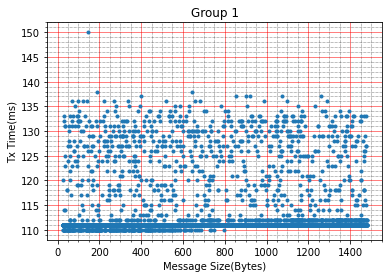

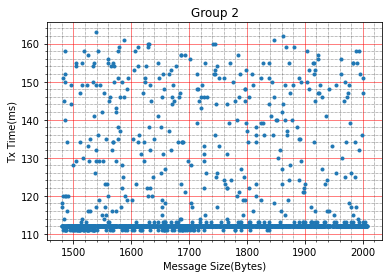

In [170]:
# Defining the groups
group1 = sort_df.iloc[:lastidx+1,1:3]
group2 = sort_df.iloc[lastidx+1:,1:3]
# Exploring the groups in table format
print(group1)
print(group2)
# Proving the number of rows are well splited in the groups
len(sort_df)==len(group1)+len(group2)

#Plotting the groups

figure5, ax1 = plt.subplots()

group1.plot(x="Message Size", y="Transmission Time", style='.', ax=ax1,legend=False)
ax1.set_xlabel('Message Size(Bytes)')
ax1.set_ylabel('Tx Time(ms)')
ax1.set_title('Group 1')

ax1.minorticks_on()
ax1.grid(which='major', linestyle='-', linewidth='0.5', color='red')
ax1.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

figure6, ax2 = plt.subplots()

group2.plot(x="Message Size", y="Transmission Time", style='.', ax=ax2,legend=False)
ax2.set_xlabel('Message Size(Bytes)')
ax2.set_ylabel('Tx Time(ms)')
ax2.set_title('Group 2')

ax2.minorticks_on()
ax2.grid(which='major', linestyle='-', linewidth='0.5', color='red')
ax2.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

f) Linear regression

In [171]:
slope1, intercept1, r1, p1, std_err1 = stats.linregress(group1['Message Size'], group1['Transmission Time'])
print('C1 = ',1/slope1, 'in (B/ms)')
print('L1 = ',intercept1,'in (ms)')
print('Std1 = ',std_err1)
print('r1index = ',r1)

def func1(x):
    return slope1 * x + intercept1

model1 = list(map(func1, group1['Message Size']))

C1 =  22119.0291398945 in (B/ms)
L1 =  113.22750958139935 in (ms)
Std1 =  0.00019380649088195773
r1index =  0.0032946888915390002


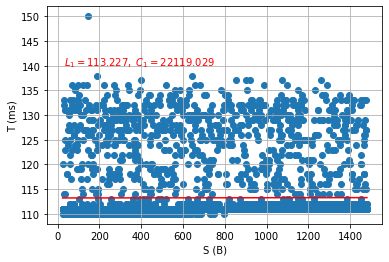

In [172]:
plt.scatter(group1['Message Size'], group1['Transmission Time'])
plt.plot(group1['Message Size'], model1, color="red")
plt.xlabel('S (B)')
plt.text(30, 140, r'$L_1=113.227,\ C_1=22119.029$',color='red')
plt.ylabel('T (ms)')
plt.grid(True)
plt.show() 

In [173]:
slope2, intercept2, r2, p2, std_err2 = stats.linregress(group2['Message Size'], group2['Transmission Time'])
print('C2 = ',1/slope2, 'in (B/ms)')
print('L2 = ',intercept2,'in (ms)')
print('Std2 = ',std_err1)
print('r2index = ',r2)

def func2(x):
    return slope2* x + intercept2

model2 = list(map(func2, group2['Message Size']))

C2 =  -554.6631211596176 in (B/ms)
L2 =  120.05358801842105 in (ms)
Std2 =  0.00019380649088195773
r2index =  -0.023209069477453173


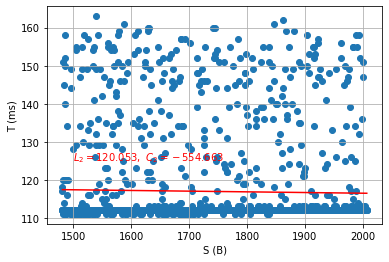

In [174]:
plt.scatter(group2['Message Size'], group2['Transmission Time'])
plt.plot(group2['Message Size'], model2, color="red")
plt.xlabel('S (B)')
plt.text(1500, 125, r'$L_2=120.053,\ C_2=-554.663$',color='red')
plt.ylabel('T (ms)')
plt.grid(True)
plt.show() 